In [6]:
import pybamm

In [7]:
model = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [8]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})

In [9]:
# Define degradation cycling experiment 
cycles_between_rpt = 10
total_cycles = 100
number_rpt_experiments = total_cycles//cycles_between_rpt


In [10]:
cccv_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 3V",
     "Rest for 1 hour",
    )
] * cycles_between_rpt)

# Prepare SOC for RPT experiment - depends 
# on the subsequent rpt experiment, for the
# given case we want the initial condition to
# be 4.2V fully charged to c/50 tolerance
rpt_preparation_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
    )
])

# Define RPT experiment, where the initial condition 
# is defined by the end state of the rpt preparation experiment
rpt_experiment = pybamm.Experiment([
    ("Discharge at C/3 until 3V",
     )
])

In [11]:
# Perform the degradation experiment
for rpt in range(number_rpt_experiments):
    sim = pybamm.Simulation(model, experiment=cccv_experiment, parameter_values=parameter_values)
    # Store the solution
    sol = sim.solve(starting_solution=sol if rpt!=0 else None)
    # option 1, do the RPT preparation experiment then the RPT experiment
    sim = pybamm.Simulation(model, experiment=rpt_preparation_experiment, parameter_values=parameter_values)
    sol = sim.solve(starting_solution=sol)
    sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
    sol = sim.solve(starting_solution=sol)
    
    
    

In [12]:
len(sol.summary_variables['Measured capacity [A.h]'])

120

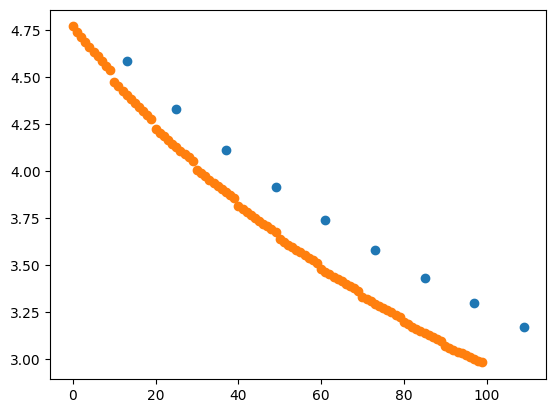

In [26]:
import matplotlib.pyplot as plt
import numpy as np

cycles = sol.summary_variables['Cycle number']
capacities = sol.summary_variables['Measured capacity [A.h]']

rpt_capacity = capacities[cycles_between_rpt+2::cycles_between_rpt+2]
rpt_cycles = cycles[cycles_between_rpt+2::cycles_between_rpt+2]

degradation_capacities = []
degradation_cycles = np.arange(total_cycles)
for i in np.arange(1,cycles[-1], cycles_between_rpt+2):
    degradation_capacities.append(capacities[i:i+10])

plt.scatter(rpt_cycles, rpt_capacity)
plt.scatter(degradation_cycles, degradation_capacities)



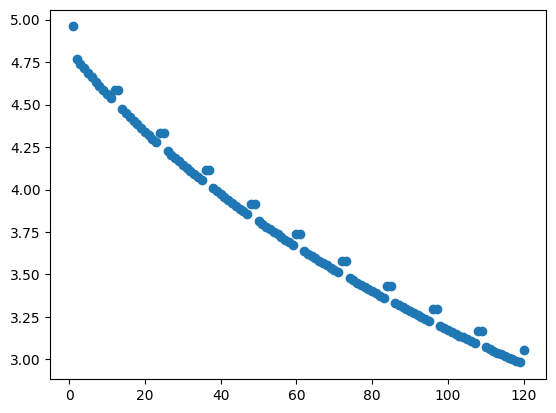

In [20]:
plt.scatter(cycles, capacities)

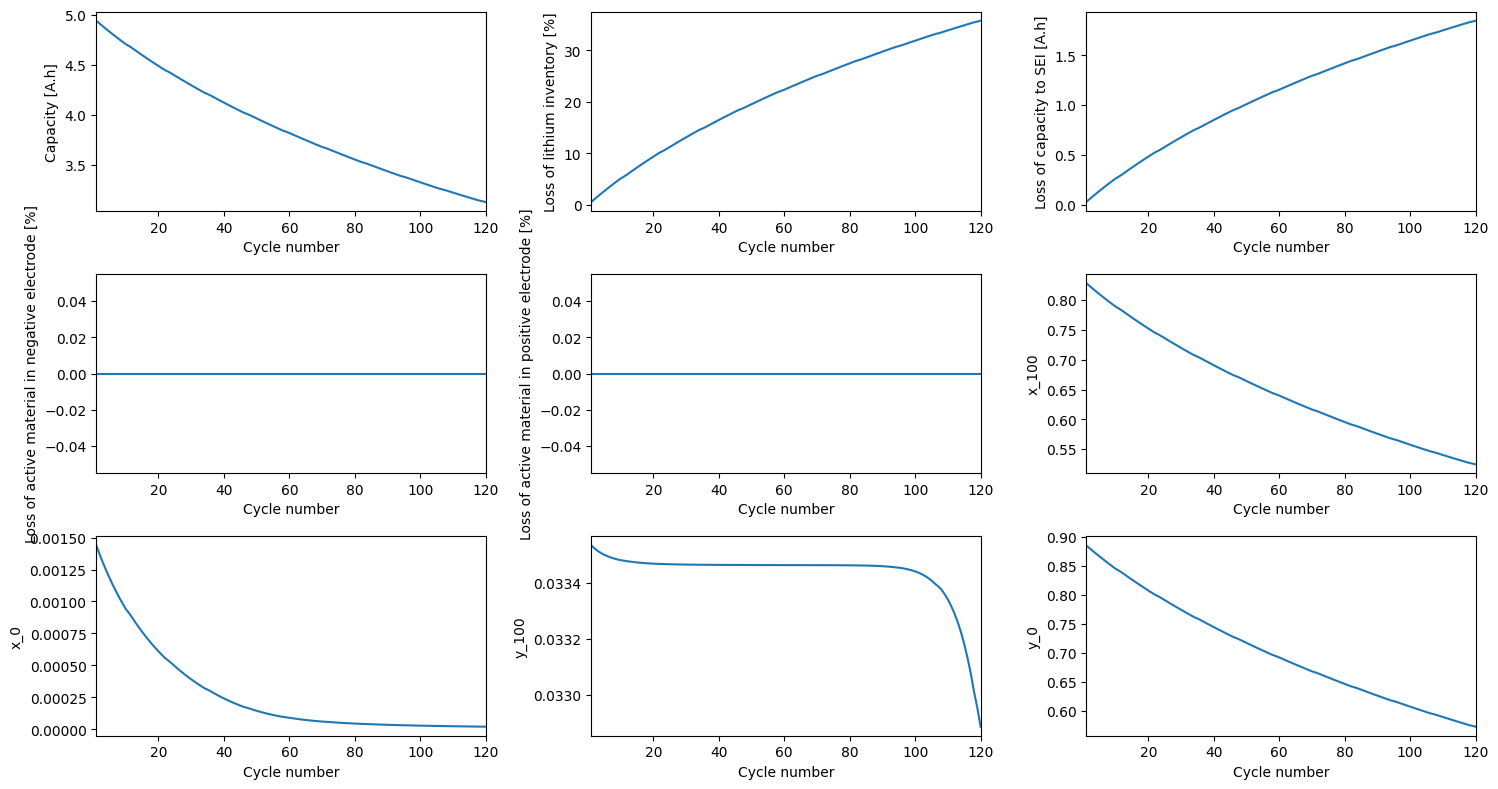

In [52]:
# Plot summary variables
pybamm.plot_summary_variables(rpt_sol);

In [ ]:
# option 1, do the RPT preparation experiment then the RPT experiment
sim = pybamm.Simulation(model, experiment=rpt_preparation_experiment, parameter_values=parameter_values)
charge_sol = sim.solve(starting_solution=cccv_sol)
sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
rpt_sol = sim.solve(starting_solution=charge_sol)

In [ ]:
pybamm.dynamic_plot(rpt_sol.cycles[-1], ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=32.16021205096371, description='t', max=34.910964032167946, min=32.160…

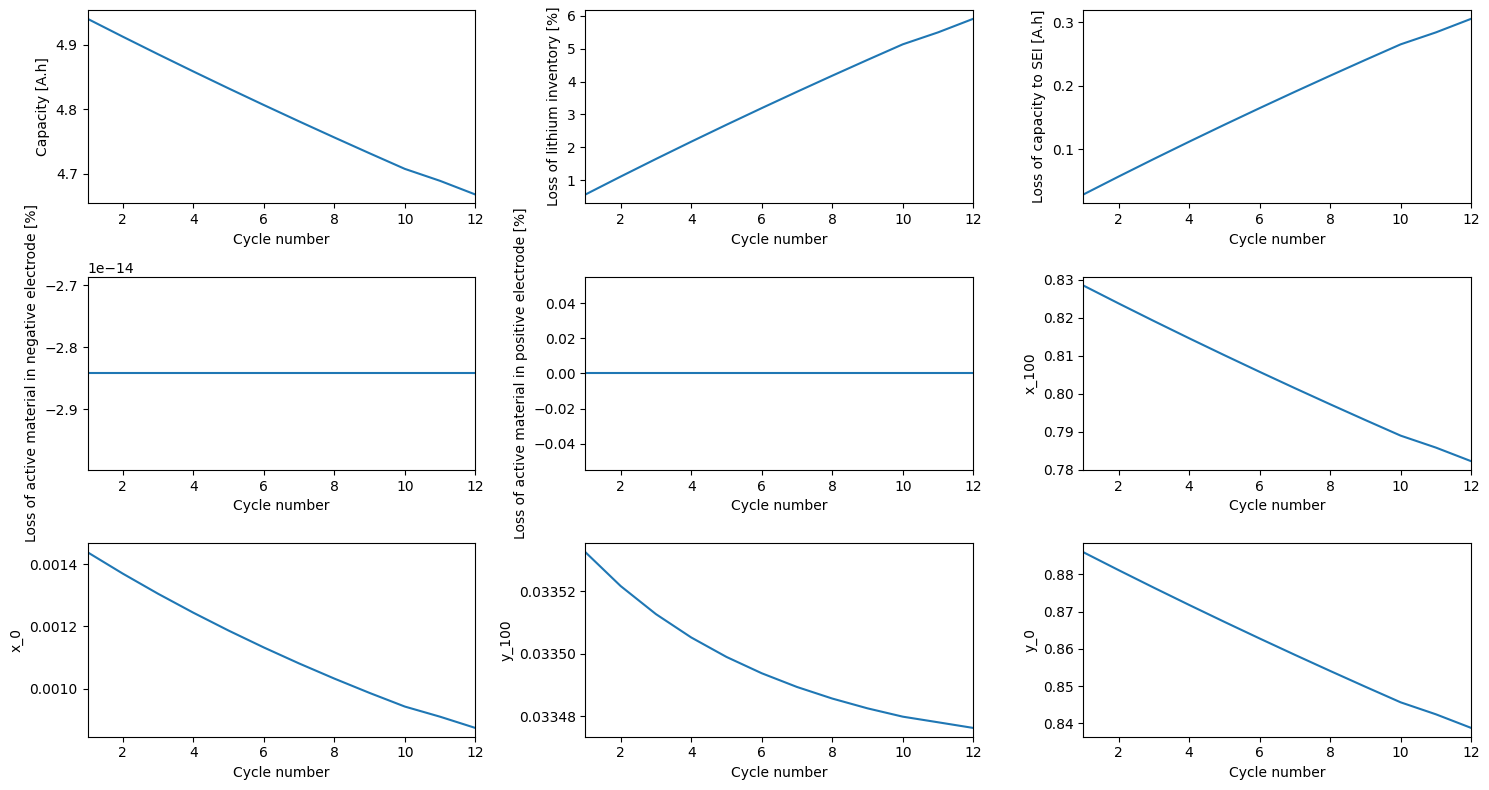

In [ ]:
pybamm.plot_summary_variables(rpt_sol);

In [ ]:
# option 2, set soc then do the RPT